# <center> 02807 - Computational Tools for Data Science </center>


# <center> Week 8 <center>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# <center> Today: Intro to Apache Spark <center>

Goals for today's lecture:
* Understanding **basic concepts and terminology of Spark** (there are quite a few!)
* Getting started with data manipulation in **PySpark**


![spark_logo](https://upload.wikimedia.org/wikipedia/commons/thumb/f/f3/Apache_Spark_logo.svg/320px-Apache_Spark_logo.svg.png)

# Apache Spark

* Open-source, distributed, cluster-computing framework. 

* Built-in modules for streaming, SQL, machine learning, graph processing

* Polyglot: Scala, Java, **Python**, R and SQL APIs

* Started as a research project at UC Berkeley in 2009

* Has become the de facto standard framework for distributed big data processing

* Built by more thant 1400 developers from more than 200 companies





# Spark and Distributed computing

* Spark is a **framework** designed for **distributed** data processing on computer **clusters**
* Single machines do not have enough power and resources to perform
computations on huge datasets
* When datasets get too big, or when data comes in too fast, it can become too much for a single computer to handle
* Instead of trying to process a huge dataset or run computationally-expensive operations on one computer, tasks can be divided between multiple computers that communicate with each other to produce an output.

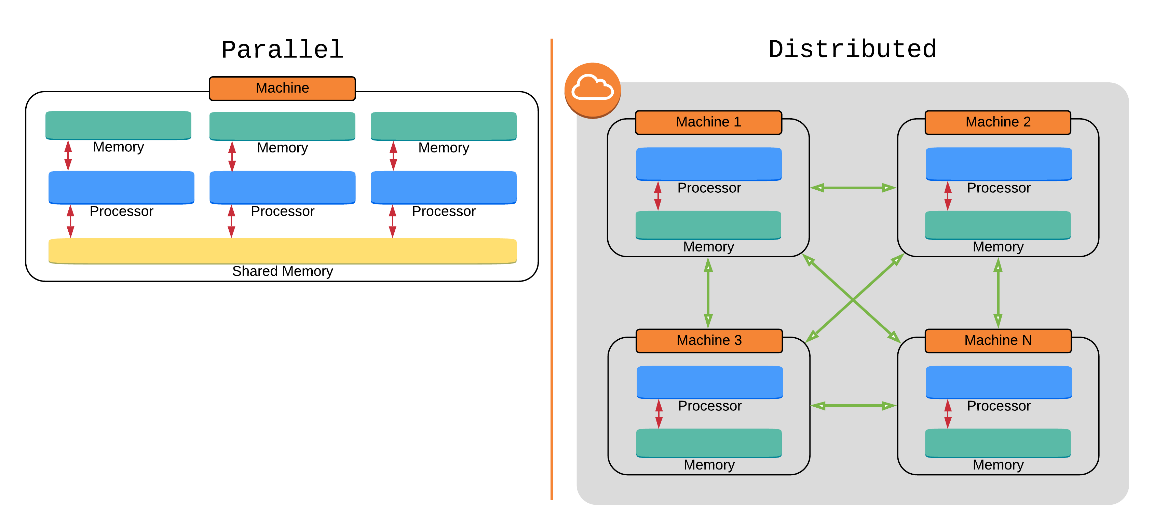
* [Image source](https://medium.com/@ManningBooks/explaining-mapreduce-with-ducks-f643c78e0b40)



* In a **distributed computing system**, each individual computer is often called a **node** and the collection of all of them is called a **cluster**
* A cluster alone is not powerful
* You need **processing engine**/**processing framework** to **coordinate work** across computers. 
* **Spark** is a processing framework: it manages and coordinates the execution of tasks on data across a cluster of computers.


# Spark Architecture

* **Spark Cluster**: treats many machines as one machine via a master-worker architecture
* **Driver**:
 * sits on a node in the cluster
 * analyses, distributes, and schedules work across the
executors.

 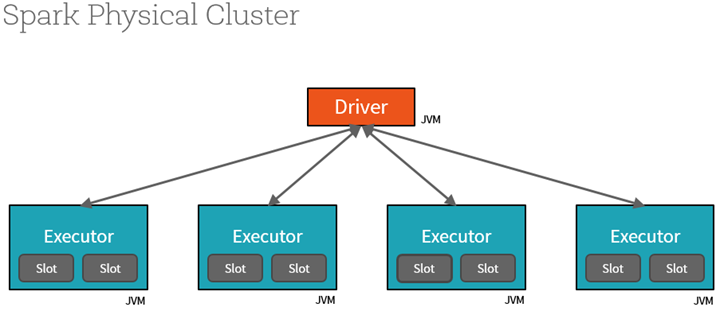

* The driver sends tasks to the empty slots on the **executors** when work has to be done:

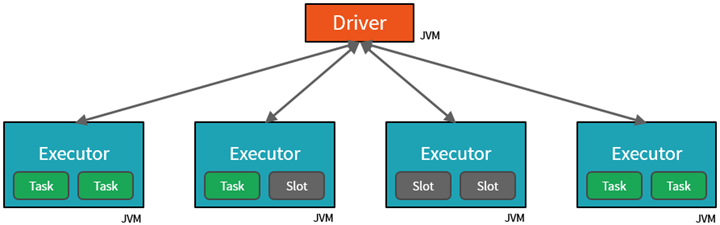

[Images' source](https://databricks-prod-cloudfront.cloud.databricks.com/public/4027ec902e239c93eaaa8714f173bcfc/346304/2168141618055043/484361/latest.html)



# Data representation in Spark

## RDDs: the basic data structure in Spark

RDD = Resilient Distributed Datasets

* **Resilient**: i.e. **fault-tolerant** with the help of **immutability** and the **RDD lineage graph** (ensures that we can recompute missing or damaged partitions due to node failures).
 * **Immutability**: once an RDD has been created, it is impossible to alter it.
 * **Lineage graph**: keeps track of where an RDD comes from.
 ![Lineage graph](https://2.bp.blogspot.com/-7z9pTkw0EBs/Wn4ocfDTmII/AAAAAAAAEHM/yobSB13veOwwoIR2loy0p2wm-bF6miEqgCLcBGAs/s1600/RDDLineage.JPG)

* **Distributed**: data is partitioned and distributed across multiple nodes
* **Dataset**: collection of partitioned data


## Spark DataFrame

* Not to be confused with Pandas DataFrames!
* Has all of the features of RDDs.
* Data is organized into named columns, like a table in a relational database.
* Optimisations and performance improvements (Catalyst optimisation, discussed later!).

![RDD vs DataFrames](https://files.training.databricks.com/images/105/rdd-vs-dataframes.png)

Image source: Databricks

# Creating a Spark session and reading some data

## Setup

Let's setup Spark on your Colab environment.

In [ ]:
!pip install pyspark
!pip install -U -q PyDrive
!apt install openjdk-8-jdk-headless -qq
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"

In [ ]:
# Let's import the libraries we will need
import pyspark
from pyspark.sql import *
from pyspark.sql import functions as f
from pyspark.sql.types import *
from pyspark import SparkContext, SparkConf

Next, let's initialise a **Spark Session**. 
* A SparkSession object is the entry point to the Spark functionality. 
* When you create the SparkSession object, it initiates a **Spark Application** which all the code for that Session will run on.


In [ ]:
# create the Spark session
conf = SparkConf().set("spark.ui.port", "4050")
sc = pyspark.SparkContext(conf=conf)
spark = SparkSession.builder.getOrCreate()

## Spark UI

* We can easily check the current version and get the link of the web interface, **Spark UI**. 
* In the Spark UI, you can monitor the progress of your job and debug the performance bottlenecks (if your Colab is running with a **local runtime**).

In [ ]:
spark

* If you are running the notebook on Colab (i.e., on the Google hosted runtime), the cell below will create a *ngrok* tunnel which will allow you to still check the Spark UI.

In [ ]:
!wget https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
!unzip ngrok-stable-linux-amd64.zip
get_ipython().system_raw('./ngrok http 4050 &')
!curl -s http://localhost:4040/api/tunnels | python3 -c \
    "import sys, json; print(json.load(sys.stdin)['tunnels'][0]['public_url'])"

# A note on ngrok

* If the code cell above gives an index error the first time, run it again and choose [A]ll. It should provide a link the second time around.

* DTUSecure wifi networks block ngork. You may need to run it on a different network, connected via ethernet or on a mobile hotspot.

* The tunnel provider (ngrok) has a limit of the number of connections or resources loaded in a given time. 

* Spark UI has a lot of links to images, scripts, etc., so we can go through the limit quickly. 

* To play around with Spark UI, it's best to:
 * run the notebook locally on your computer, or
 * sign up for a [Databricks Community Edition](https://community.cloud.databricks.com/login.html) account (free), which offers notebooks with nicely integrated Spark UI



## Reading data into a DataFrame


Let's load some data to work with.

In [ ]:
from google.colab import drive
# This will prompt for authorization.

drive.mount('/content/drive')

import os
import urllib.request
tit=urllib.request.urlretrieve('https://raw.githubusercontent.com/plotly/datasets/master/titanic.csv','/content/sample_data/titanic.csv')

!ls '/content/sample_data'

We specify that we want to interpret the first line as headers and that we want Spark to try to infer the types of the data.

In [ ]:
df = spark.read.option('header', True).option('inferSchema', True).csv('/content/sample_data/titanic.csv')

## Inspecting the file

- Check that it looks ok (`show()`)
- Check that the schema is correct (`printSchema()`)

In [ ]:
df.show()
df.printSchema()

# Working with immutable data

* In Spark, the core data structures are immutable

*  This might seem like a strange concept at first. If you cannot change the data, how are you supposed to use it? 

* In order to "change" a DataFrame you have to tell Spark how you would like to transform the existing DataFrame into a new one.

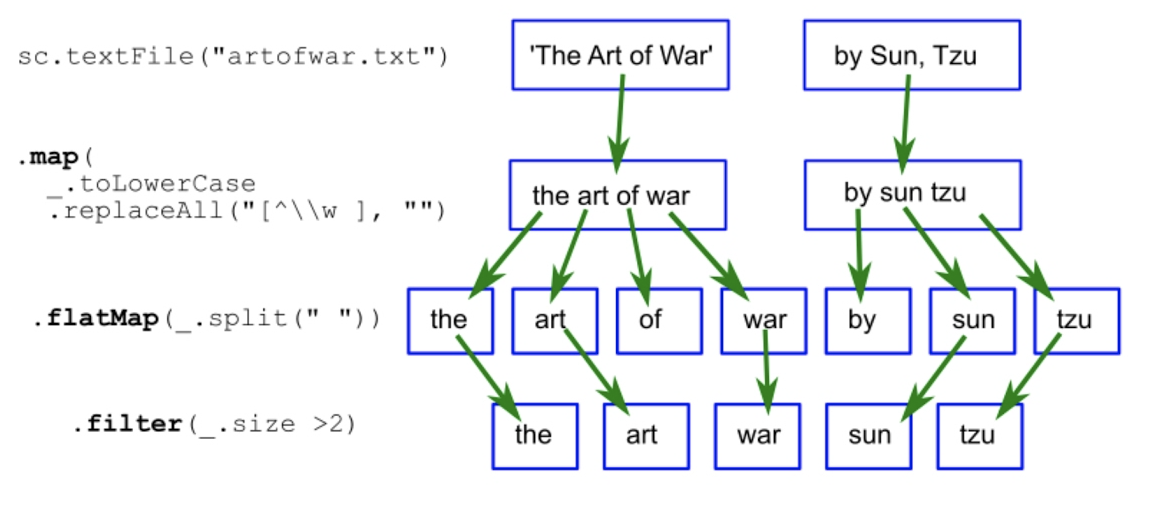

[Image source](https://www.youtube.com/watch?v=AYpoFCE7Uy0&ab_channel=MicheleSciabarra)


# Spark operations: transformations vs actions

The operations you can do within a Spark application are divided into two types:

* **Transformations**: 

    * when applied to an DataFrame, they return a new DataFrame created via the transformation.
    * examples: ``filter`` (returns an DataFrame with those elements that pass a condition) and ``sortBy`` (returns a sorted DataFrame). 

* **Actions**: 

    * when applied to an DataFrame, they return a non-DataFrame output.
    * example: ``count`` (returns the number of rows in DataFrame to the Spark driver),  ``collect`` (sends the contents of a DataFrame to the driver).


## Narrow vs. wide transformations

* **Narrow transformation**: 
    * when applied on an RDD, there is no data movement between partitions. 
    * each partition of the parent RDD is used by at most one partition of the child RDD
    * example: ``filter``, ``union``


* **Wide transformation**:

    * requires data movement between partitions, which is known as **shuffle**. 
    * the data is moved across the network and the partitions of the newly-created RDD are based on the data of multiple input partitions.
    * example: ``sortBy``, ``count``


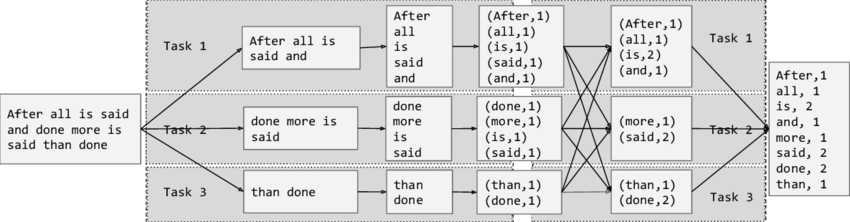

##  Filtering (narrow transformation example)

In [ ]:
filtered_df = df.filter(f.col('survived') == True).filter(f.col('Cabin').isNotNull())

In [ ]:
filtered_df.show()

## Sorting (wide transformation example)
Only sort when you really need it and when the dataframe is small. It is an expensive operation.

In [ ]:
df.sort(df["Name"]).show()

The same, using ``orderBy``.

In [ ]:
df.orderBy('Name').show()

# Lazy evaluation in Spark

Fundamental to Spark:
* Transformations are **LAZY**
* Actions are **EAGER**

In other words:
 * Instead of running the transformations one by one as soon as it receives them, Spark stores these transformations in a **DAG** (Directed Acyclic Graph)
 * As soon as it receives an action, it runs the whole DAG and delivers the requested output.


In [ ]:
# chaining transformations
# the transformed dataframes are not created
(df
 .sort(df["Name"])
 .filter(f.col('survived') == True))

Now let's add a ``show`` action. Spark will now submit a **job** to deliver the requested output.

In [ ]:
(df
 .sort(df["Name"])
 .filter(f.col('survived') == True)
 .show())   #action!

# Lazy evaluation and Catalyst optimisation

* Most importantly, lazy evaluation over DataFrames allows Spark to automatically apply various optimisations

*  Spark's **Catalyst** optimiser is responsible for this. For more information, read [this blog!](https://databricks.com/blog/2015/04/13/deep-dive-into-spark-sqls-catalyst-optimizer.html)
  
![Catalyst](https://files.training.databricks.com/images/105/catalyst-diagram.png)

[Image source](https://files.training.databricks.com/images/105/catalyst-diagram.png)

### Spark UI: seeing the optimisation in action
* Go to the Spark UI
* Click on the SQL query associated with your Spark job
* See the logical and physical plans!
  * The filter and sort have been swapped

# Spark Jobs

* When you invoke an action, a **job** is created. Jobs are work submitted to Spark.
* A job will then be decomposed into single or multiple **stages**
* Each stage is divided into individual **tasks** that can be run in parallel. 
* A **task** is a single unit of work that the Spark driver ships to an executor for completion.

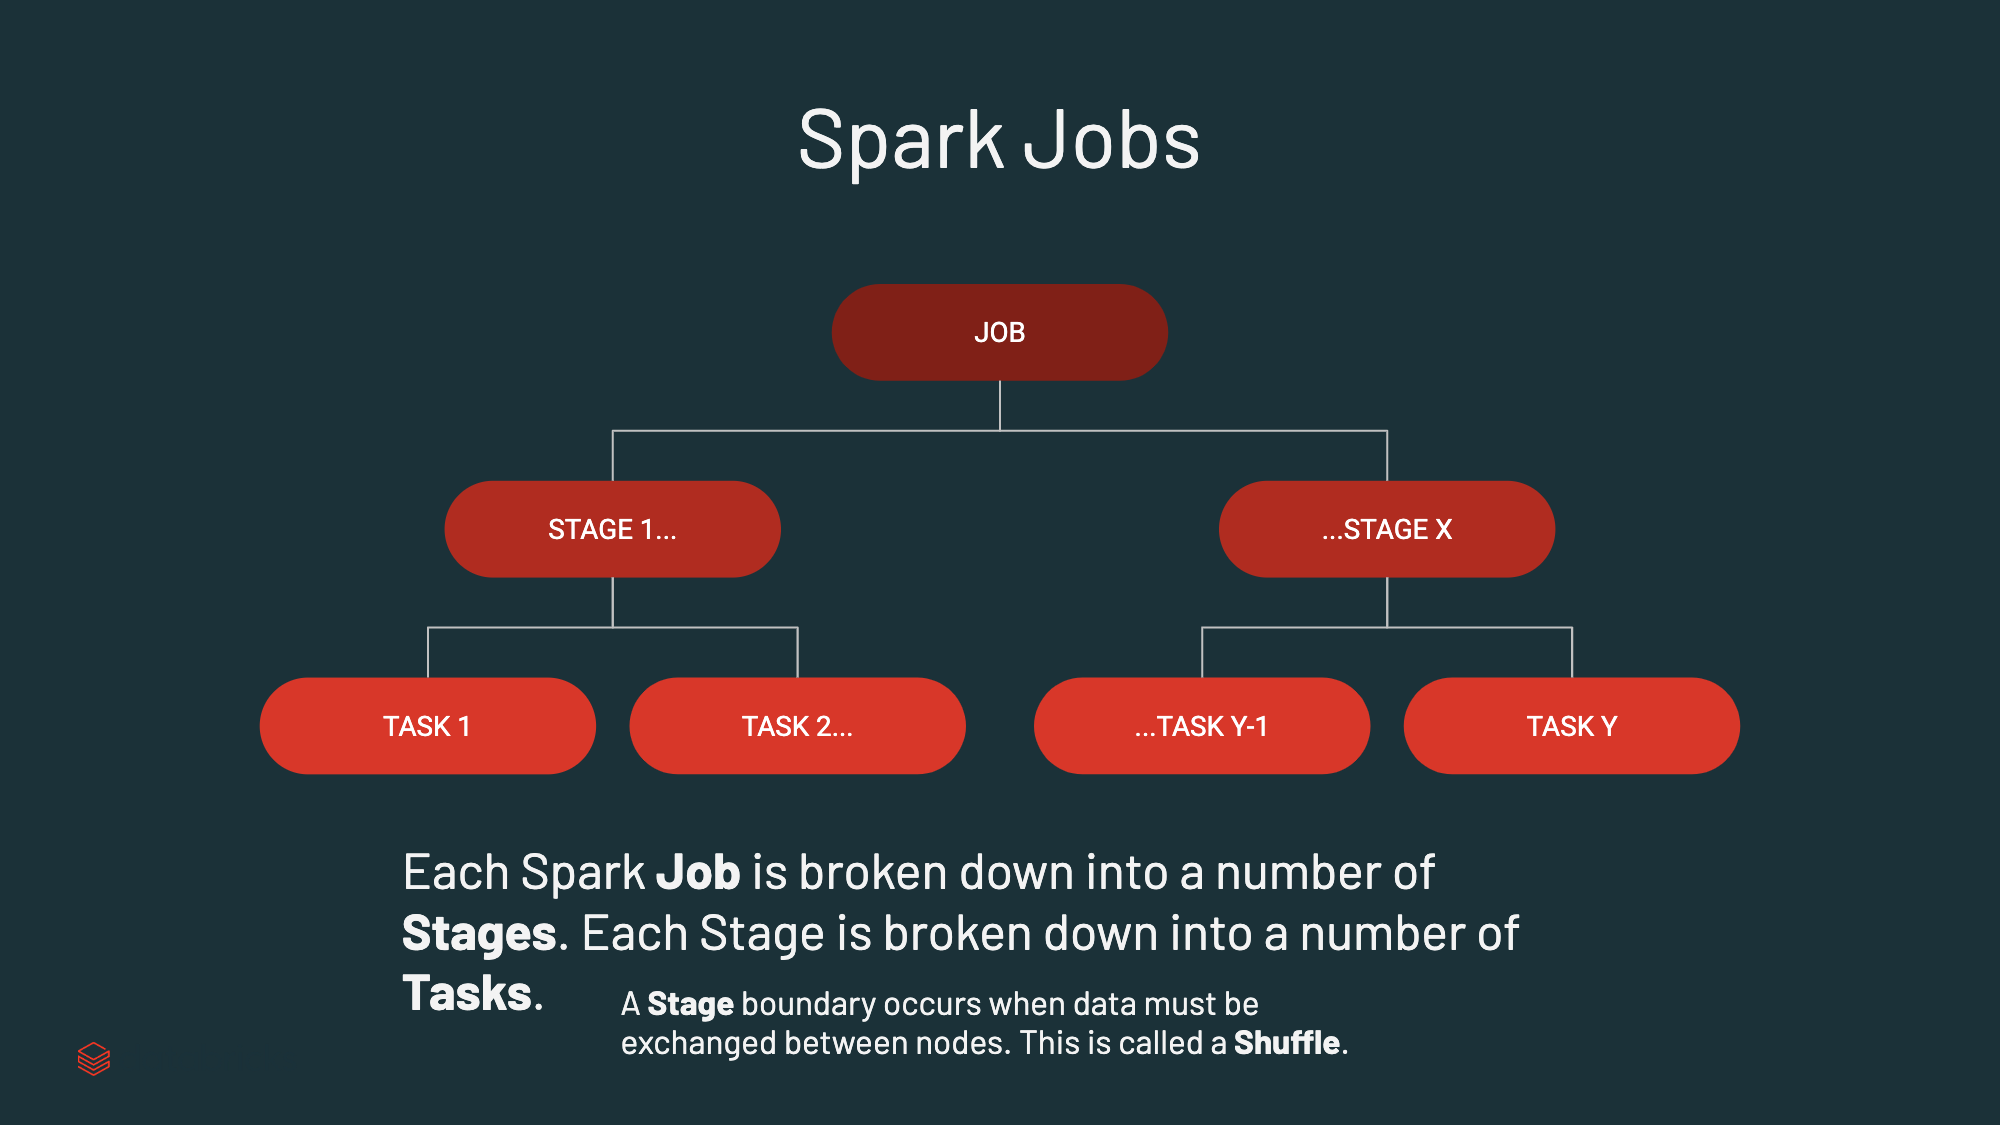


[Image source](https://github.com/databricks/tech-talks/blob/master/2020-04-29%20%7C%20Intro%20to%20Apache%20Spark/Intro%20to%20Spark.pdf)


# Example: row count

Let's trigger a job by asking Spark to count the number of rows in our dataframe.

In [ ]:
df.count()

## How many stages in the job that compute the count?


* Two stages:
 * **Stage 1**: each worker counts its own partition of the data
 * **Stage 2**: workers exchange data to compute the aggregate

* The second stage involves a shuffle (data exchange), which triggers a stage boundary.

* We can  use the Spark UI to look at the anatomy of the job triggered by the count action.
* Spark UI offers a DAG visualisation of jobs ([How to read Spark job DAGs](https://dzone.com/articles/reading-spark-dags))



## Visualising boundaries in a word count

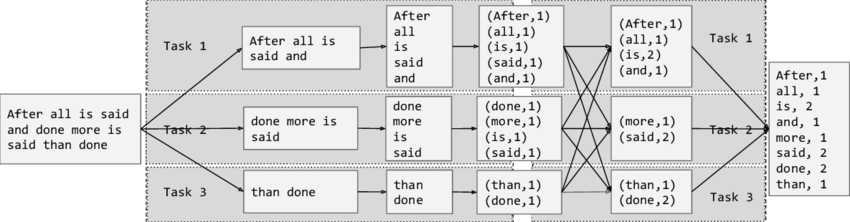

# Taking stock...

* Wow. We just covered a ton of new concepts and terminology. 

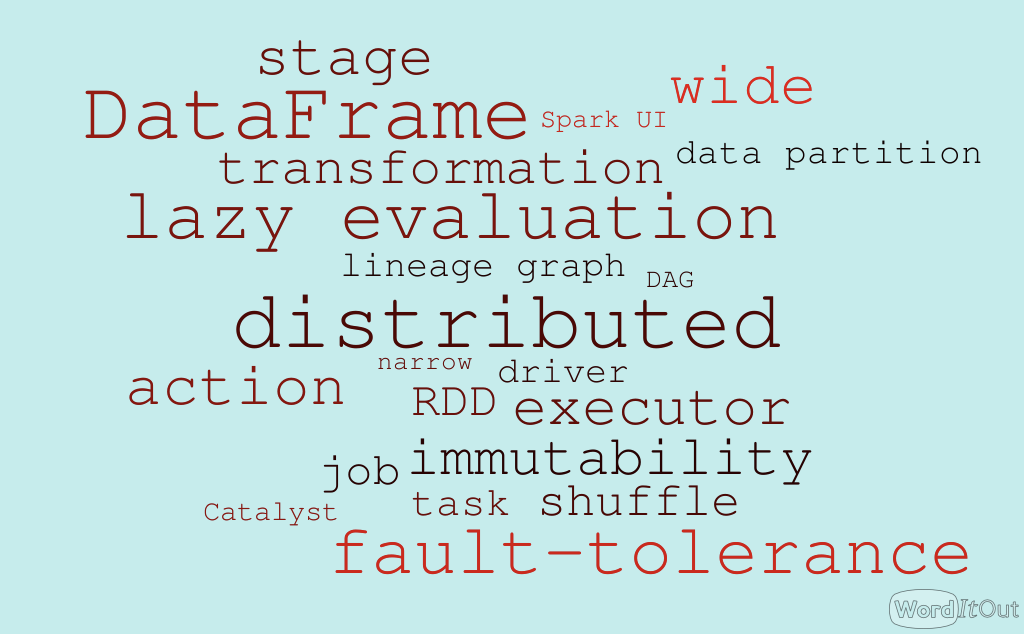

* Let's look at some Spark functionality.



# Viewing and selecting data

* To view a dataframe, use ``.show()``

* To see the data types of your dataframe, use ``.printSchema()``

* To choose certain columns we want to display, use ``.select()``

In [ ]:
df.show()

In [ ]:
df.printSchema()

Let’s view only Name, and Age in the Titanic dataframe. 

In [ ]:
df.select("Name","Age").show(15, truncate=False)

The ``truncate=False`` parameter adjusts the size of columns to prevent values from being cut off.

# Adding and removing columns

In [ ]:
drop_id_df = df.drop('PassengerId')

In [ ]:
drop_id_df.printSchema()

In [ ]:
drop_id_df.show()

In [ ]:
display(drop_id_df)

In the titanic dataset, we have the following columns:

* ``sibsp``: Number of Siblings/Spouses Aboard

* ``parch``: Number of Parents/Children Aboard

A passenger's fare is not the price of each passenger, but the price of each ticket, which is bought for the entire family. We can calculate the fare per passenger by spreading the cost amongst the family members. 

In [ ]:
(df
 .withColumn('RealFare', f.col('Fare')/(f.col('SibSp')+f.col('Parch')+1))
 .select('SibSp', 'Parch', 'Fare', 'RealFare')
 .show())

# Aggregates / summary statistics
We can also group values and compute statistics.

Functions:

- ``avg()``
- ``count()``
- ``max()``
- ``min()``
- ``sum()``

In [ ]:
# Total fare
df.select(f.sum('Fare')).show()

In [ ]:
# Total, average, max and min
df.select(f.sum('Fare'), f.avg('Fare'), f.max('Fare'), f.min('Fare')).show()

In [ ]:
# ... with filter
(df
 .filter(f.col('Fare') > 0.0) # filter out 0-fare entries
 .select(f.sum('Fare'), f.avg('Fare'), f.max('Fare'), f.min('Fare')) 
 .show())

The ``.describe()`` method produces summary statistics on columns of our choosing.

In [ ]:
df.describe(["Age","Fare"]).show()

You can also group data in a column and compute aggregates per group.

In [ ]:
# Total per passenger class
df.groupBy('Pclass').agg(f.avg('Fare')).orderBy("avg(Fare)", ascending=False).show()

# UDFs: user-defined functions
* If you want to apply your own function to a column you need to register it as a UDF. 

* UDFs can be used in a number of ways: using `select()`, `withColumn()`, `filter()`, etc.

Let's create a function that extracts the title of the passenger. Names are in the form `Lastname, Title. Firstname`.

In [ ]:
def extract_title(name):
    name_parts = name.split(',')
    title_and_first = name_parts[1].split('.')
    return title_and_first[0]

In [ ]:
extract_title_udf = f.udf(extract_title)

In [ ]:
df.withColumn('Title', extract_title_udf(f.col('Name'))).select('Name', 'Title').show()